In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import cvxpy as cp

In [2]:
file = scipy.io.loadmat("capacities.mat")
capacities = file.get("capacities")
capacities = capacities.reshape(28,)
file = scipy.io.loadmat("traveltime.mat")
traveltime = file.get("traveltime")
traveltime = traveltime.reshape(28,)
file = scipy.io.loadmat("flow.mat")
flow = file.get("flow")
flow = flow.reshape(28,)
file = scipy.io.loadmat("traffic.mat")
traffic = file.get("traffic")

In [3]:
B=traffic
le=traveltime
Ce=capacities

In [4]:
def compute_system_cost(flow,traveltime,capacities):
    return flow@(traveltime/(1-(flow/capacities)))

In [5]:
def compute_system_cost_G(flow,traveltime,capacities):
    return flow@(traveltime/(1-(flow/capacities))-traveltime)

## A

In [6]:
G=nx.DiGraph()
#construct the graph G starting from the matrix B (node link incidence matrix)
for i in range(0, B.shape[1]):
    edge_nf=0
    j=-1
    
    while edge_nf!=2:
        j+=1
        cell=B[j][i]
        if cell==1:
            edge_nf+=1
            head=j+1
        if cell==-1:
            edge_nf+=1
            tail=j+1
            
    G.add_edge(head, tail, capacity=Ce[i])

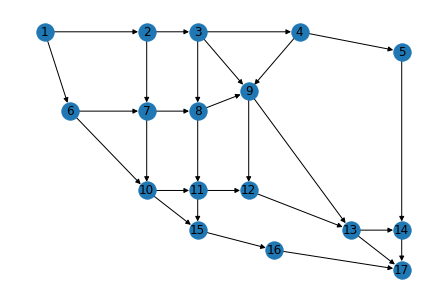

In [7]:
pos = {17:[7,0],14:[7,1],13:[6,1],1:[0,6],2:[2,6],3:[3,6],4:[5,6],5:[7,5.5],6:[0.5,4],7:[2,4],8:[3,4],9:[4,4.5],10:[2,2],11:[3,2],12:[4,2],15:[3,1],16:[4.5,0.5]}
nx.draw(G, pos, with_labels=True)

In [8]:
n_edges = len(G.edges)
tau=1
nu_base=np.zeros(17)
nu_base[0]=1
nu_base[16]=-1
nu=nu_base*tau

In [9]:
f = cp.Variable(n_edges)
objective = cp.Minimize(le.T @ f)
constraints = [B @ f == nu, f >=0,  f<=Ce]
prob = cp.Problem(objective, constraints)
result = prob.solve()

/home/giuseppegalilei/anaconda3/envs/NDL/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [10]:
print("Shortest path has value", result,"and is made of links:")
i=1
for edge_flow in f.value:
    if edge_flow >= 0.1:
        print("Link",i)
    i+=1

Shortest path has value 0.5329960020127646 and is made of links:
Link 1
Link 2
Link 9
Link 12
Link 25


### B

In [11]:
print("The maximum flow from node 1 to 17 is", nx.algorithms.flow.maximum_flow(G, 1,17)[0])

The maximum flow from node 1 to 17 is 22448


## C

In [12]:
nu_C=B@flow
print("The exogenous flow vector requested is\n",nu_C)

The exogenous flow vector requested is
 [ 16806   8570  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


## D

In [13]:
nu_base=np.zeros(17)
nu_D=nu
nu_D[0]=nu_C[0]
nu_D[16]=-nu_C[0]

In [14]:
f = cp.Variable(n_edges)
lc=le*Ce
objective=cp.Minimize(cp.sum(cp.multiply(lc,(cp.inv_pos(1-cp.multiply(f,cp.inv_pos(Ce))))) - lc))
constraints = [B @ f == nu_D, f >=0,  f<=Ce]
prob = cp.Problem(objective, constraints)
result = prob.solve()

In [15]:
f_o=f.value
result_o=result
print("The social optimum cost is:", result_o)
print("The social optimum flow is:\n", f_o)

The social optimum cost is: 25943.62261121288
The social optimum flow is:
 [6.64219910e+03 6.05893789e+03 3.13232779e+03 3.13232589e+03
 1.01638009e+04 4.63831664e+03 3.00634073e+03 2.54263460e+03
 3.13154448e+03 5.83261212e+02 1.45164550e-02 2.92659559e+03
 1.89781986e-03 3.13232589e+03 5.52548426e+03 2.85427264e+03
 4.88644874e+03 2.21523712e+03 4.63720641e+02 2.33768761e+03
 3.31799129e+03 5.65567890e+03 2.37310712e+03 1.99567283e-03
 6.41411626e+03 5.50543301e+03 4.88645073e+03 4.88645073e+03]


## E

In [16]:
f = cp.Variable(n_edges)
lc=le*Ce
objective=cp.Minimize(cp.sum(-lc@cp.log(1-f/Ce)))
constraints = [B @ f == nu_D, f >=0,  f<=Ce]
prob = cp.Problem(objective, constraints)
result = prob.solve()

In [17]:
f_w=f.value
result_w=result
print("The user cost in wardrop is:", result_w)
print("The user optimum flow is:\n", f_w)

The user cost in wardrop is: 15729.60710343099
The user optimum flow is:
 [6.71564895e+03 6.71564803e+03 2.36740801e+03 2.36740792e+03
 1.00903510e+04 4.64539489e+03 2.80384316e+03 2.28356194e+03
 3.41848003e+03 9.22328268e-04 1.76829408e+02 4.17141061e+03
 8.92024178e-05 2.36740792e+03 5.44495611e+03 2.35317044e+03
 4.93333832e+03 1.84155266e+03 6.97110629e+02 3.03649261e+03
 3.05028094e+03 6.08677356e+03 2.58651143e+03 1.24029072e-04
 6.91874216e+03 4.95391934e+03 4.93333845e+03 4.93333845e+03]


In [18]:
wardrop_cost = compute_system_cost(f_w,le,Ce)
print("The respective costs on the system are:")
print("\tSocial optimum cost: {:.3f}\n\tWardrop cost: {:.3f}".format(result_o,wardrop_cost))
print("\nPrice of anarchy: {:.3f}".format(wardrop_cost/result_o))

The respective costs on the system are:
	Social optimum cost: 25943.623
	Wardrop cost: 26292.964

Price of anarchy: 1.013


## F

In [19]:
tolls=f_o*le*Ce*1/(np.power(Ce-f_o, 2))

In [20]:
f = cp.Variable(n_edges)
lc=le*Ce
objective = cp.Minimize(cp.sum(cp.multiply(-lc,cp.log1p(cp.multiply(-f,cp.inv_pos(Ce)))) + cp.multiply(tolls,f)))
constraints = [B @ f == nu_D, f >=0,  f<=Ce]
prob = cp.Problem(objective, constraints)
result = prob.solve()

In [21]:
f_t=f.value
result_t=result
print("The user cost in wardrop with tolls is:", result_t)
print("The user optimum flow with tolls is:\n", f_t)

The user cost in wardrop with tolls is: 61885.75828419042
The user optimum flow with tolls is:
 [6.64297510e+03 6.05907793e+03 3.13247156e+03 3.13247145e+03
 1.01630248e+04 4.63825748e+03 3.00632468e+03 2.54233942e+03
 3.13149039e+03 5.83897168e+02 4.41635538e-04 2.92660593e+03
 1.13364091e-04 3.13247145e+03 5.52476733e+03 2.85422618e+03
 4.88637111e+03 2.21582997e+03 4.63985699e+02 2.33745508e+03
 3.31821174e+03 5.65566682e+03 2.37303573e+03 1.44842042e-04
 6.41412148e+03 5.50550718e+03 4.88637126e+03 4.88637126e+03]


In [22]:
wardrop_cost = compute_system_cost(f_w,le,Ce)
wardrop_withtolls_cost=compute_system_cost(f_t,le,Ce)
print("The respective costs on the system are:")
print("\tSocial optimum cost: {:.3f}\n\tWardrop cost: {:.3f}\n\tWardrop with tolls cost: {:.3f}".format(result_o,wardrop_cost, wardrop_withtolls_cost))

The respective costs on the system are:
	Social optimum cost: 25943.623
	Wardrop cost: 26292.964
	Wardrop with tolls cost: 25943.622


# G

In [23]:
lc=le*Ce
objective = cp.Minimize(cp.sum(cp.multiply(lc,(cp.inv_pos(1-cp.multiply(f,cp.inv_pos(Ce))))) - lc - cp.multiply(f, le)))
constraints = [B @ f == nu_D, f >=0,  f<=Ce]
prob = cp.Problem(objective, constraints)
result = prob.solve()

In [24]:
f_o_G=f.value
result_o_G=result
print("The social optimum cost is:", result_o_G)
print("The social optimum flow is:\n", f_o_G)

The social optimum cost is: 15095.51352460787
The social optimum flow is:
 [6.65329658e+03 5.77466230e+03 3.41971657e+03 3.41971062e+03
 1.01527034e+04 4.64278036e+03 3.10584008e+03 2.66218478e+03
 3.00907935e+03 8.78634280e+02 7.42401749e-03 2.35493830e+03
 5.94907576e-03 3.41971062e+03 5.50992306e+03 3.04369256e+03
 4.88180506e+03 2.41557456e+03 4.43662730e+02 2.00804968e+03
 3.48735309e+03 5.49540277e+03 2.20377848e+03 2.20338871e-03
 6.30070364e+03 5.62348910e+03 4.88180726e+03 4.88180726e+03]


In [25]:
f = cp.Variable(n_edges)
lc=le*Ce
objective=cp.Minimize(cp.sum(cp.multiply(-lc,cp.log1p(cp.multiply(-f,cp.inv_pos(Ce)))) - cp.multiply(f, le)))
constraints = [B @ f == nu_D, f >=0,  f<=Ce]
prob = cp.Problem(objective, constraints)
result = prob.solve()

In [26]:
f_w_G=f.value
result_w_G=result
print("The user cost in wardrop is:", result_w_G)
print("The user optimum flow is:\n", f_w_G)

wardrop_cost_G = compute_system_cost_G(f_w_G,le,Ce)
print("\nThe respective costs on the system are:")
print("\tSocial optimum cost: {:.3f}\n\tWardrop cost: {:.3f}".format(result_o_G,wardrop_cost_G))
print("\nPrice of anarchy: {:.3f}".format(wardrop_cost_G/result_o_G))

The user cost in wardrop is: 5014.4918319848575
The user optimum flow is:
 [6.78171861e+03 6.00489674e+03 3.26626641e+03 3.26625120e+03
 1.00242813e+04 4.66556349e+03 3.02889540e+03 2.64103584e+03
 3.03881982e+03 7.76821866e+02 2.40309308e+02 2.49832102e+03
 1.52097660e-02 3.26625120e+03 5.35871777e+03 2.88151993e+03
 4.89068780e+03 2.41348995e+03 6.28168876e+02 2.10055225e+03
 3.50968657e+03 5.61023882e+03 2.26259310e+03 2.23404877e-03
 6.38646554e+03 5.52884430e+03 4.89069003e+03 4.89069003e+03]

The respective costs on the system are:
	Social optimum cost: 15095.514
	Wardrop cost: 15148.087

Price of anarchy: 1.003


In [27]:
tolls_G=f_o_G*le*Ce*1/(np.power(Ce-f_o_G, 2))

In [28]:
f = cp.Variable(n_edges)
lc=le*Ce
objective = cp.Minimize(cp.sum(cp.multiply(-lc,cp.log1p(cp.multiply(-f,cp.inv_pos(Ce))))- cp.multiply(f, le) + cp.multiply(tolls_G,f)))
constraints = [B @ f == nu_D, f >=0,  f<=Ce]
prob = cp.Problem(objective, constraints)
result = prob.solve()

In [29]:
f_t_G=f.value
result_t_G=result
print("The user cost in wardrop with tolls is:", result_t_G)
print("The user optimum flow with tolls is:\n", f_t_G)

The user cost in wardrop with tolls is: 50795.960339220146
The user optimum flow with tolls is:
 [6.65313125e+03 5.77541915e+03 3.41948032e+03 3.41947910e+03
 1.01528686e+04 4.64242340e+03 3.10549352e+03 2.66173288e+03
 3.00916867e+03 8.77712096e+02 1.51897306e-03 2.35593731e+03
 1.22684777e-03 3.41947910e+03 5.51044520e+03 3.04337504e+03
 4.88171213e+03 2.41464197e+03 4.43762163e+02 2.00850274e+03
 3.48713672e+03 5.49563946e+03 2.20406969e+03 4.88393528e-04
 6.30073844e+03 5.62354878e+03 4.88171262e+03 4.88171262e+03]


In [30]:
wardrop_cost_G = compute_system_cost_G(f_w_G,le,Ce)
wardrop_withtolls_cost_G=compute_system_cost_G(f_t_G,le,Ce)
print("The respective costs on the system are:")
print("\tSocial optimum cost: {:.3f}\n\tWardrop cost: {:.3f}\n\tWardrop with tolls cost: {:.3f}".format(result_o_G,wardrop_cost_G, wardrop_withtolls_cost_G))

The respective costs on the system are:
	Social optimum cost: 15095.514
	Wardrop cost: 15148.087
	Wardrop with tolls cost: 15095.513
